In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1224.02it/s]


In [2]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_layers=4):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))
        t = torch.arange(-block_size, 0)
        self.register_buffer("alibi", torch.tril(torch.cat([t, t[:-1]]).unfold(0, len(t), 1).flip(0)))

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv(self.ln1(x)).chunk(3, dim=-1)
        w = q @ k.transpose(-2, -1)
        w = w + self.alibi[:T, :T]
        w.masked_fill_(self.mask[:T, :T], float("-Inf"))
        w = F.softmax(w, dim=-1)
        attn = self.proj(w @ v)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=40, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 207 K 
-------------------------------
207 K     Trainable params
0         Non-trainable params
207 K     Total params
0.829     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]And nowVwqm,eEE3c''oeEscK:sVKj ;N$ Is&Rb-QLHmqxZrMRcHmNqysVc'UkfEFh,UJB
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 209/209 [00:08<00:00, 24.41it/s, loss=1.86, v_num=73]And now do no,
I dry that so is, a and baning the pare she straighter t
Epoch 1: 100%|██████████| 209/209 [00:07<00:00, 28.31it/s, loss=1.63, v_num=73, test_loss=1.940]And now,
Have make this. But, ald somet for wrees having of his him you
Epoch 2: 100%|██████████| 209/209 [00:07<00:00, 28.32it/s, loss=1.53, v_num=73, test_loss=1.760]And now me are him what send
An her in of my from so did take all;--
Wi
Epoch 3: 100%|██████████| 209/209 [00:07<00:00, 28.31it/s, loss=1.48, v_num=73, test_loss=1.690]And now yet,
It that men? Come, I am which as my hunded
I have moce is 
Epoch 4: 100%|██████████| 209/209 [00:07<00:00, 26.70it/s, loss=1.44, v_num=73, test_loss=1.610]And now.

Pronounted
They bear week; no wild so, for the lies;
Behold t
Epoch 5: 100%|██████████| 209/209 [00:07<00:00, 27.49it/s, loss=1.43, v_num=73, test_loss=1.610]And now, here;
And, sir; I will ten thy same, of had not and we maid, s
Epoch 6: 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 209/209 [00:12<00:00, 16.87it/s, loss=1.21, v_num=73, test_loss=1.410]


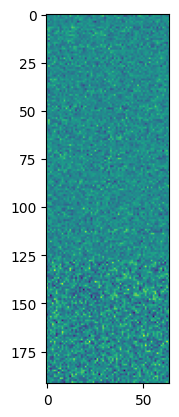

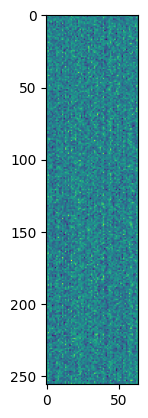

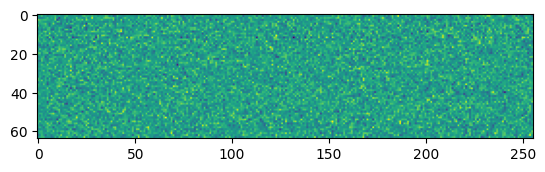

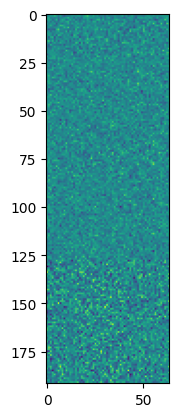

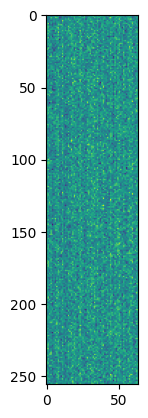

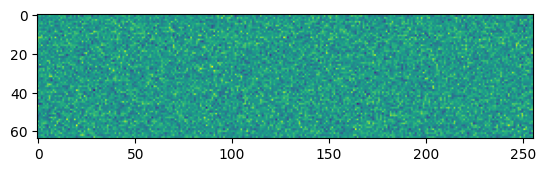

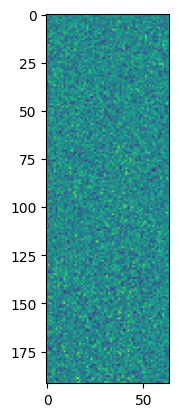

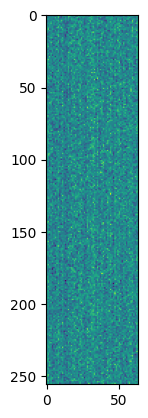

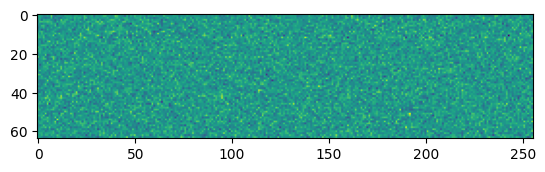

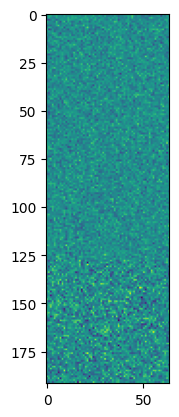

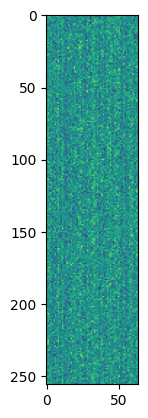

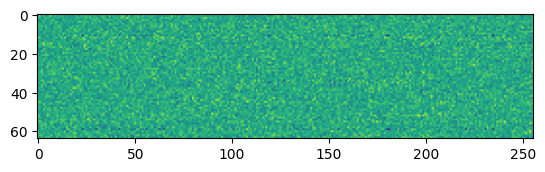

In [4]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.qkv.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [5]:
print(model.generate("O God, O God!", 1024))

O God, O God!' what which woe there's son.

GLAUNTIO:
Now will your fathers.

Like Maminal both:
The betwixt our slaughter; age, I cannot for my turn:
Thine obduard? What says yourselves but on the world is no make for his weak of the tardy her ten against Strault Watchman:
That more of life: and sickness
The pleasure this mindless fear, and she lights; and, wear the duke is towns,
And therefore services as your duke,
Summers your dissensible and forth our pins of my lawfully?

GLOUCESTER:
A great, their heads.

MERCUTIO:
Bad answer.

Post:
High.

KING HENRY VI:
Neight i' the middle falsehood! for the time
Or taken will set them blood, and therefore, and I ne'er what hath patience
So let this. Strike! What's the sunshines that thou lay:
His protection our fellows for him to them
He leave o' them to thy thee
In possess'd as I behold overcask;
And, as he in thy tongue impart till I mean thou made thyself
I never dying being but
Integativous are we bought of stocks this dukedom's body hav